In [77]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2, fftshift
import matplotlib.pyplot as plt
from seaborn import heatmap

# Parameters from the model
sigma2 = 2.0  # Variance of low-frequency fluctuations
L_2d = 15_000.0    # Mesoscale length scale (meters)
psi = np.deg2rad(45)       # Anisotropy parameter (angle in radians or as described)
z_i = 500.0    # Attenuation length (boundary-layer height, meters)

c = (8 * sigma2) / (9 * L_2d**(2/3))

# Domain parameters
L1, L2 = 40 * L_2d, 5 * L_2d
N1, N2 = 2**10, 2**7  # Grid points in longitudinal and transverse directions
dx, dy = L1 / N1, L2 / N2  # Grid spacings (meters)

print(f"Physical parameters: \n\t sigma2 = {sigma2:.2f},\n\t L_2d = {L_2d:.2f},\n\t psi = {psi:.2f},\n\t z_i = {z_i:.2f}")
print(f"Obtained c: {c:.2f}")
print(f"Domain parameters: \n\t L1 = {L1:.2f},\n\t L2 = {L2:.2f},\n\t N1 = {N1},\n\t N2 = {N2},\n\t dx = {dx:.2f},\n\t dy = {dy:.2f}")

Physical parameters: 
	 sigma2 = 2.00,
	 L_2d = 15000.00,
	 psi = 0.79,
	 z_i = 500.00
Obtained c: 0.00
Domain parameters: 
	 L1 = 600000.00,
	 L2 = 75000.00,
	 N1 = 1024,
	 N2 = 128,
	 dx = 585.94,
	 dy = 585.94


In [78]:
def numerical_debug(some_arr):

    print("Max: ", np.max(some_arr))
    print("Min: ", np.min(some_arr))
    print("Mean: ", np.mean(some_arr))
    print("Median: ", np.median(some_arr))
    print("Shape: ", some_arr.shape)

    if len(some_arr.shape) == 2:
        heatmap(some_arr)
    print()

In [79]:
# Frequency space setup

# k1_arr = fftshift(2 * np.pi * fftfreq(N1, d=dx))
# k2_arr = fftshift(2 * np.pi * fftfreq(N2, d=dy))

k1_arr = (2 * np.pi * fftfreq(N1, d=dx))
k2_arr = (2 * np.pi * fftfreq(N2, d=dy))

print(k1_arr.shape)
print(k2_arr.shape)

k1, k2 = np.meshgrid(k1_arr, k2_arr)


(1024,)
(128,)


Max:  0.005351179486614614
Min:  -0.00536165146212658
Mean:  -5.2359877559830445e-06
Median:  -5.235987755982989e-06
Shape:  (128, 1024)

(128, 1024)
(128, 1024)


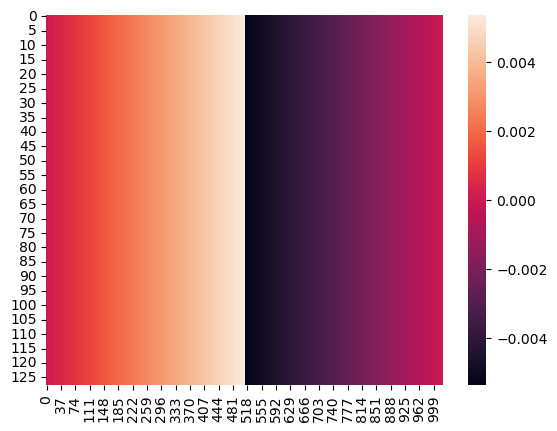

In [80]:
numerical_debug(k1)

print(k1.shape)
print(k2.shape)


Max:  0.007582520214456945
Min:  0.0
Mean:  0.004102810052617375
Median:  0.004278221752296182
Shape:  (128, 1024)

Max:  0.007582520214456944
Min:  0.0
Mean:  0.004102810052617375
Median:  0.0042782217522961815
Shape:  (128, 1024)



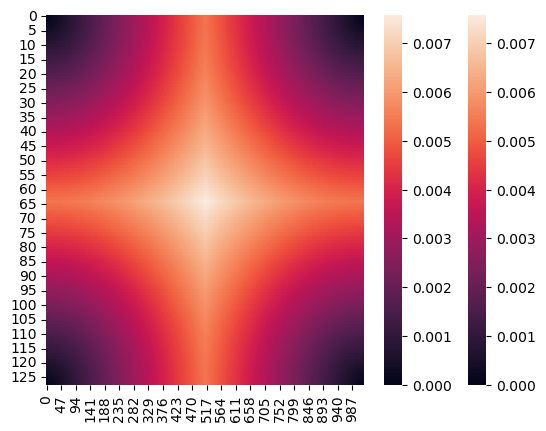

In [81]:
# Spectrum implementation

kappa = np.sqrt(2 * ((k1 * np.cos(psi)) ** 2 + (k2 * np.sin(psi)) ** 2))
k_mag = np.sqrt(k1**2 + k2**2)  # Magnitude of wavenumber

numerical_debug(k_mag)
numerical_debug(kappa)

Max:  5816.214267785924
Min:  0.0
Mean:  36.9429090505525
Median:  4.646846076464016
Shape:  (128, 1024)



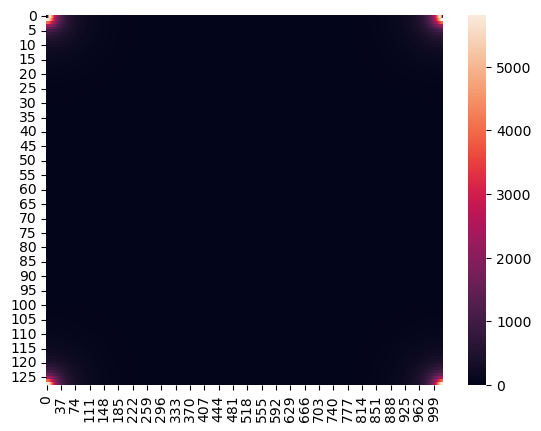

In [82]:
E_kappa_attenuated = (
    c * (kappa**3)
) / ( 
    (((L_2d**-2) + kappa**2)**(7/3)) * (1 + (kappa * z_i)**2)
)

numerical_debug(E_kappa_attenuated)

In [83]:
kappa.shape

(128, 1024)

In [84]:
mask = np.isclose(kappa, 0.0)

_intermediate = E_kappa_attenuated / np.pi 

# phi_common = np.where(mask,  _intermediate / kappa, 0.0)

phi_common = np.zeros_like(kappa, dtype=float)

for i in range(N2):
    for j in range(N1):
        if np.isclose(kappa[i, j], 0.0):
            phi_common[i, j] = 0.0
        else:
            phi_common[i, j] = _intermediate[i, j] / kappa[i, j]


Max:  25637602.49895703
Min:  0.0
Mean:  28594.144074507276
Median:  345.73641371417494
Shape:  (128, 1024)



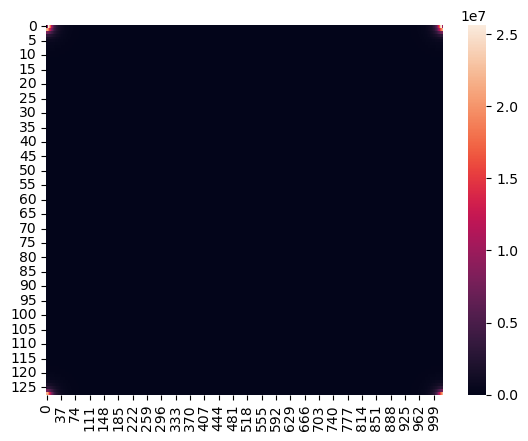

In [85]:
numerical_debug(phi_common)

In [86]:
# NOTE: Here we are currently leaving k in, only using kappa in the energy spectrum
mask = k_mag > 0

phi_11 = np.zeros_like(phi_common, dtype=float)
phi_12 = np.zeros_like(phi_common, dtype=float)
phi_22 = np.zeros_like(phi_common, dtype=float)

# phi_11 = np.where(mask, phi_common * (1 - (k1 / k_mag)**2), 0.0)
# phi_12 = np.where(mask, phi_common * (-1 * (k1 * k2) / k_mag**2), 0.0)
# phi_21 = phi_12
# phi_22 = np.where(mask, phi_common * (1 - (k2 / k_mag)**2), 0.0)

for i in range(N2):
    for j in range(N1):
        if mask[i, j]:
            phi_11[i, j] = phi_common[i, j] * (1 - (k1[i, j] / k_mag[i, j])**2)
            phi_12[i, j] = phi_common[i, j] * (-1 * (k1[i, j] * k2[i, j]) / k_mag[i, j]**2)
            phi_22[i, j] = phi_common[i, j] * (1 - (k2[i, j] / k_mag[i, j])**2)



Max:  22001974.559128497
Min:  0.0
Mean:  13954.11116133722
Median:  134.63140913933503
Shape:  (128, 1024)



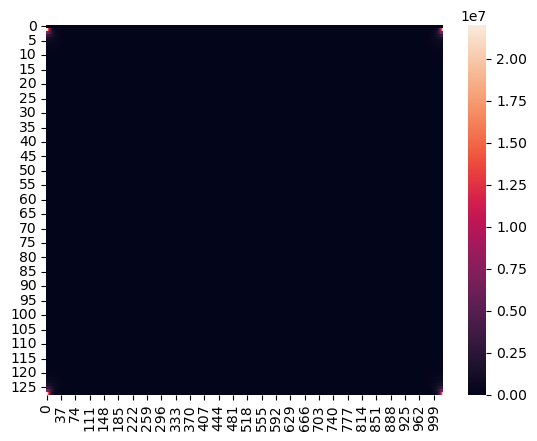

In [87]:
numerical_debug(phi_11)


Max:  8331818.731468237
Min:  -8331818.731468237
Mean:  -0.0001040164170350022
Median:  0.0
Shape:  (128, 1024)



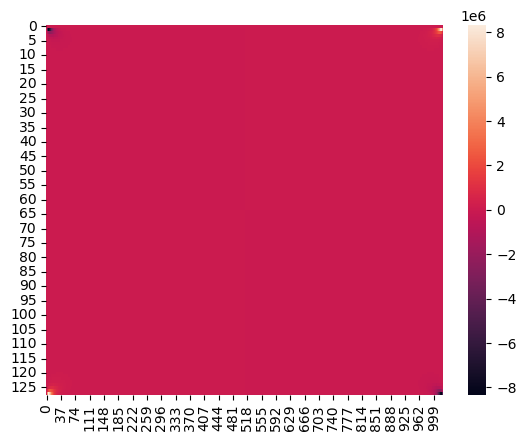

In [88]:
numerical_debug(phi_12)

Max:  0.13893268871937173
Min:  0.0
Mean:  0.0009609026266103027
Median:  0.0003436741024952361
Shape:  (128, 1024)



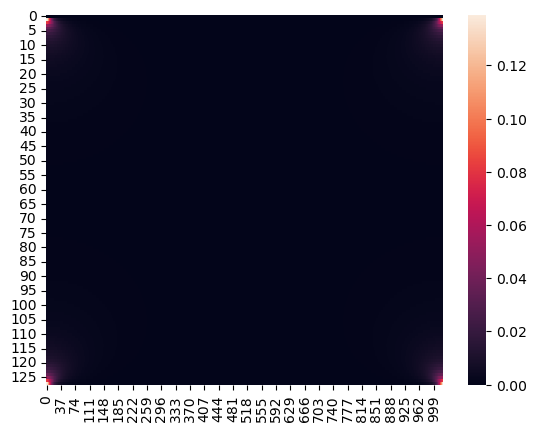

In [89]:
# Cij(k) now. Here is done by equation 15

C_11 = np.sqrt((2 * np.pi)**2 / (L1 * L2) * phi_11)
C_22 = np.sqrt((2 * np.pi)**2 / (L1 * L2) * phi_22)

numerical_debug(C_11)

Max:  8331818.731468237
Min:  -8331818.731468237
Mean:  -0.0001040164170350022
Median:  0.0
Shape:  (128, 1024)



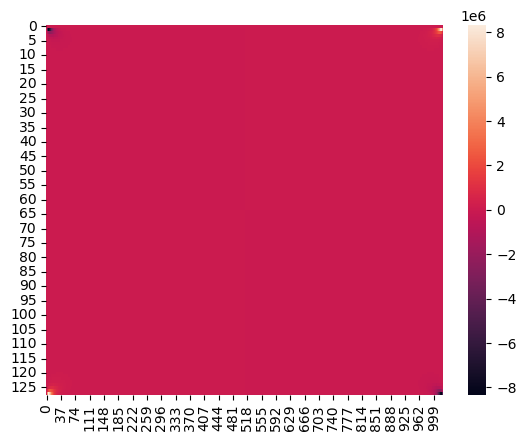

In [90]:
# C_12 = np.sqrt((2 * np.pi)**2 / (L1 * L2) * phi_12)  # No cross-correlation for simplicity

C_12 = np.zeros_like(phi_12)

for i in range(N2):
    for j in range(N1):
        if mask[i, j]:
            C_12[i, j] = phi_12[i, j]


numerical_debug(C_12)

In [91]:
# eta_1 = np.random.normal(0, 1, size=(N1, N2)) + 1j * np.random.normal(0, 1, size=(N1, N2))
# eta_2 = np.random.normal(0, 1, size=(N1, N2)) + 1j * np.random.normal(0, 1, size=(N1, N2))
eta_1 = np.random.normal(0, 1, size=(N2, N1)) + 1j * np.random.normal(0, 1, size=(N2, N1))
eta_2 = np.random.normal(0, 1, size=(N2, N1)) + 1j * np.random.normal(0, 1, size=(N2, N1))

In [92]:
print(C_11.shape)
print(C_12.shape)
print(C_22.shape)
print(eta_1.shape)
print(eta_2.shape)


(128, 1024)
(128, 1024)
(128, 1024)
(128, 1024)
(128, 1024)


In [93]:
u1 = np.real(ifft2((C_11 * eta_1) + (C_12 * eta_2)))  # Longitudinal component
u2 = np.real(ifft2((C_12 * eta_1) + (C_22 * eta_2)))  # Transverse component

Variance of u1: 142404.5690, Variance of u2: 207603.1310
Target variance: 2.0000


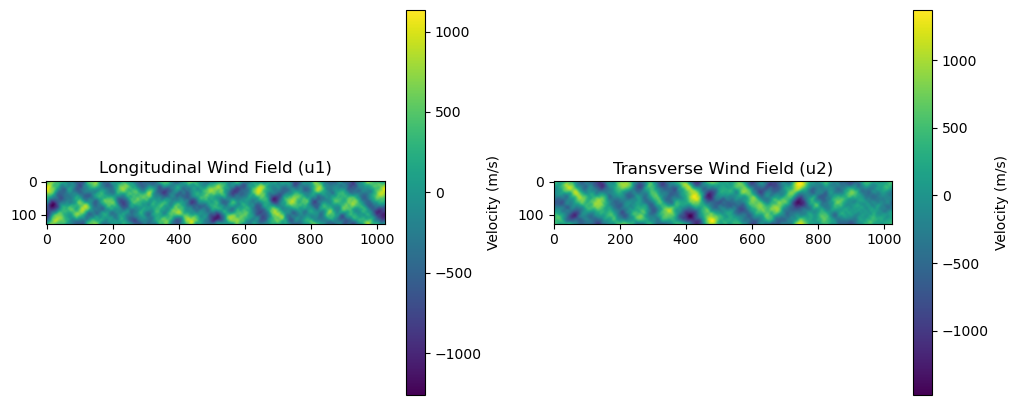

In [94]:
# Verify total variance (should match sigma_2d^2)
var_u1 = np.var(u1)
var_u2 = np.var(u2)
print(f"Variance of u1: {var_u1:.4f}, Variance of u2: {var_u2:.4f}")
print(f"Target variance: {sigma2:.4f}")

# Plot the wind field
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(u1, cmap='viridis')
plt.title('Longitudinal Wind Field (u1)')
plt.colorbar(label='Velocity (m/s)')

plt.subplot(122)
plt.imshow(u2, cmap='viridis')
plt.title('Transverse Wind Field (u2)')
plt.colorbar(label='Velocity (m/s)')
plt.show()

In [ ]:
# import numpy as np
# from scipy.fft import fft2, fftfreq, fftshift

# Example data
# n_x, n_y = 128, 128  # Grid size
# dx, dy = 0.1, 0.1    # Grid spacing (in physical units, e.g., meters)
# u_long = np.random.randn(Nx, Ny)  # Replace with your longitudinal array

# Step 1: Compute 2D FFT
U = fft2(u1)
U_shifted = fftshift(U)  # Shift zero frequency to center

# Step 2: Compute wavenumbers
k_x = fftshift(fftfreq(N1, d=dx)) * 2 * np.pi  # Wavenumber in x (longitudinal)
k_y = fftshift(fftfreq(N2, d=dy)) * 2 * np.pi  # Wavenumber in y (transverse)

# Step 3: Compute 2D PSD
psd_2d = np.abs(U_shifted)**2 / (N1 * N2)  # Normalize by grid size

# Step 4: Average over transverse direction (k_y) to get F11(k_1)
F11 = np.mean(psd_2d, axis=1) * (N1 * dy)  # Integrate over k_y, adjust normalization

# Step 5: Corresponding k_1 wavenumbers
k1 = k_x  # Longitudinal wavenumbers

# Optional: Check total energy (Parseval's theorem)
energy_spatial = np.mean(u1**2) * (N1 * dx) * (N2 * dy)
energy_spectral = np.sum(F11) * (k1[1] - k1[0])  # dk_1 spacing
print(f"Spatial energy: {energy_spatial:.4f}, Spectral energy: {energy_spectral:.4f}")

# Plot (optional)
import matplotlib.pyplot as plt
plt.loglog(k1[k1 > 0], F11[k1 > 0], label='F11(k1)')
plt.xlabel('k1 (longitudinal wavenumber)')
plt.ylabel('F11 (energy spectrum)')
plt.legend()
plt.show()